In [ ]:
!pip install tensorflow==1.15.0
!pip install tensorflow-gpu==1.15.0
!pip install keras==2.0.8
!pip install segments-ai 
!pip install -U scikit-image==0.16.2
!pip install 'h5py==2.10.0' --force-reinstall

In [ ]:
!git clone https://github.com/CChristenson1/Mask_RCNN.git

# Mask R-CNN Maize 

A full pipeline to import, train and predict on new maize images.

In [ ]:
import os
import sys
import os.path as osp
import json
import numpy as np
import skimage.io
import datetime
from PIL import Image
from argparse import ArgumentParser
from skimage.measure import regionprops
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist.'

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn.model import log

import maize.maize as maize

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


... done downloading pretrained model!


In [ ]:
%load_ext autoreload
%autoreload maize.maize

## Image Prep


In [ ]:
if not osp.exists("../datasets"):
  os.mkdir("../datasets")
!python maize/image_prep.py API_KEY v0.3 -o ../datasets/full  -d Cchristenson3/Maize_Images reviewed -c 1

### Make Validation set

In [ ]:
image_names = next(os.walk("/content/Mask_RCNN/datasets/full/Cchristenson3_Maize_Images/v0.3"))[2]
image_ids = [
            image_name.split(".")[0]
            for image_name in image_names
            if ((not image_name.split("_")[-1] in ["label.png","ground-truth.png"]) and (image_name.split(".")[1] == "png"))
        ]  

train, val = train_test_split(image_ids, train_size= .8)
maize.VAL_IMAGE_IDS = val
maize.LIST_IMAGE_IDS = train
print(len(image_ids),len(train),len(val))

### NO need to run Unless you want to use preset splits

In [ ]:
ten_val = ['1165_1_429', '1414_1_1203']
ten_train = ['1405_1_1203', '1399_2_1203', '1175_1_429', '1107_2_515', '1155_3_515', '1400_1_1203', '1135_1_515', '1165_3_429']

twenty_val = ['1165_1_429', '1414_1_1203', '1396_3_1203', '1125_3_515']
twenty_train = ['1405_1_1203', '1399_2_1203', '1175_1_429', '1107_2_515', '1155_3_515', '1400_1_1203', '1135_1_515', '1165_3_429',
                '1137_3_429', '1393_1_1203', '1818_3_1203', '1145_3_429', '1420_2_1203', '1806_3_1203', '1397_1_1203', '1808_1_1203']

thirty_val = ['1165_1_429', '1414_1_1203', '1396_3_1203', '1125_3_515', '1403_3_1203', '1399_1_1203']
thirty_train = ['1405_1_1203', '1399_2_1203', '1175_1_429', '1107_2_515', '1155_3_515', '1400_1_1203', '1135_1_515', '1165_3_429',
                '1137_3_429', '1393_1_1203', '1818_3_1203', '1145_3_429', '1420_2_1203', '1806_3_1203', '1397_1_1203', '1808_1_1203',
                '1155_2_515', '1795_2_1203', '1408_3_1203', '1806_2_1203', '1145_2_429', '1400_2_1203', '1419_3_1203', '1175_3_429']

fourty_val = ['1165_1_429', '1414_1_1203', '1396_3_1203', '1125_3_515', '1403_3_1203', '1399_1_1203','1793_2_1203', '1654_2']
fourty_train = ['1405_1_1203', '1399_2_1203', '1175_1_429', '1107_2_515', '1155_3_515', '1400_1_1203', '1135_1_515', '1165_3_429',
                '1137_3_429', '1393_1_1203', '1818_3_1203', '1145_3_429', '1420_2_1203', '1806_3_1203', '1397_1_1203', '1808_1_1203',
                '1155_2_515', '1795_2_1203', '1408_3_1203', '1806_2_1203', '1145_2_429', '1400_2_1203', '1419_3_1203', '1175_3_429',
                '1795_3_1203', '1416_3_1203', '1413_3_1203', '1393_2_1203', '1417_1_1203', '1125_2_515', '1818_1_1203', '1131_2_515']

fifty_val = ['1165_1_429', '1414_1_1203', '1396_3_1203', '1125_3_515', '1403_3_1203', '1399_1_1203','1793_2_1203', '1654_2', '1412_1_1203', '1404_2_1203']
fifty_train = ['1405_1_1203', '1399_2_1203', '1175_1_429', '1107_2_515', '1155_3_515', '1400_1_1203', '1135_1_515', '1165_3_429',
                '1137_3_429', '1393_1_1203', '1818_3_1203', '1145_3_429', '1420_2_1203', '1806_3_1203', '1397_1_1203', '1808_1_1203',
                '1155_2_515', '1795_2_1203', '1408_3_1203', '1806_2_1203', '1145_2_429', '1400_2_1203', '1419_3_1203', '1175_3_429',
                '1795_3_1203', '1416_3_1203', '1413_3_1203', '1393_2_1203', '1417_1_1203', '1125_2_515', '1818_1_1203', '1131_2_515',
               '1393_3_1203', '1410_3_1203', '1137_1_429', '1409_2_1203', '1131_1_515', '1405_2_1203', '1808_2_1203', '1787_1_1203']

sixty_val = ['1165_1_429', '1414_1_1203', '1396_3_1203', '1125_3_515', '1403_3_1203', '1399_1_1203','1793_2_1203', '1654_2', '1412_1_1203', '1404_2_1203', '1153_2_429', '1412_3_1203']
sixty_train = ['1405_1_1203', '1399_2_1203', '1175_1_429', '1107_2_515', '1155_3_515', '1400_1_1203', '1135_1_515', '1165_3_429',
                '1137_3_429', '1393_1_1203', '1818_3_1203', '1145_3_429', '1420_2_1203', '1806_3_1203', '1397_1_1203', '1808_1_1203',
                '1155_2_515', '1795_2_1203', '1408_3_1203', '1806_2_1203', '1145_2_429', '1400_2_1203', '1419_3_1203', '1175_3_429',
                '1795_3_1203', '1416_3_1203', '1413_3_1203', '1393_2_1203', '1417_1_1203', '1125_2_515', '1818_1_1203', '1131_2_515',
               '1393_3_1203', '1410_3_1203', '1137_1_429', '1409_2_1203', '1131_1_515', '1405_2_1203', '1808_2_1203', '1787_1_1203',
               '1408_2_1203', '1415_1_1203', '1416_1_1203', '1175_2_429', '1408_1_1203', '1808_3_1203', '1798_1_1203', '1810_2_1203']

seventy_val = ['1165_1_429', '1414_1_1203', '1396_3_1203', '1125_3_515', '1403_3_1203', '1399_1_1203','1793_2_1203', '1654_2', '1412_1_1203', '1404_2_1203', '1153_2_429', '1412_3_1203', '1403_2_1203', '1806_1_1203']
seventy_train = ['1405_1_1203', '1399_2_1203', '1175_1_429', '1107_2_515', '1155_3_515', '1400_1_1203', '1135_1_515', '1165_3_429',
                '1137_3_429', '1393_1_1203', '1818_3_1203', '1145_3_429', '1420_2_1203', '1806_3_1203', '1397_1_1203', '1808_1_1203',
                '1155_2_515', '1795_2_1203', '1408_3_1203', '1806_2_1203', '1145_2_429', '1400_2_1203', '1419_3_1203', '1175_3_429',
                '1795_3_1203', '1416_3_1203', '1413_3_1203', '1393_2_1203', '1417_1_1203', '1125_2_515', '1818_1_1203', '1131_2_515',
               '1393_3_1203', '1410_3_1203', '1137_1_429', '1409_2_1203', '1131_1_515', '1405_2_1203', '1808_2_1203', '1787_1_1203',
               '1408_2_1203', '1415_1_1203', '1416_1_1203', '1175_2_429', '1408_1_1203', '1808_3_1203', '1798_1_1203', '1810_2_1203',
               '1395_3_1203', '1135_2_515', '1397_2_1203', '1796_2_1203', '1401_3_1203', '1404_1_1203', '1818_2_1203', '1397_3_1203']

eighty_val = ['1165_1_429', '1414_1_1203', '1396_3_1203', '1125_3_515', '1403_3_1203', '1399_1_1203','1793_2_1203', '1654_2', '1412_1_1203', '1404_2_1203', '1153_2_429', '1412_3_1203', '1403_2_1203', '1806_1_1203', '1402_1_1203', '1145_1_429']
eighty_train = ['1405_1_1203', '1399_2_1203', '1175_1_429', '1107_2_515', '1155_3_515', '1400_1_1203', '1135_1_515', '1165_3_429',
                '1137_3_429', '1393_1_1203', '1818_3_1203', '1145_3_429', '1420_2_1203', '1806_3_1203', '1397_1_1203', '1808_1_1203',
                '1155_2_515', '1795_2_1203', '1408_3_1203', '1806_2_1203', '1145_2_429', '1400_2_1203', '1419_3_1203', '1175_3_429',
                '1795_3_1203', '1416_3_1203', '1413_3_1203', '1393_2_1203', '1417_1_1203', '1125_2_515', '1818_1_1203', '1131_2_515',
               '1393_3_1203', '1410_3_1203', '1137_1_429', '1409_2_1203', '1131_1_515', '1405_2_1203', '1808_2_1203', '1787_1_1203',
               '1408_2_1203', '1415_1_1203', '1416_1_1203', '1175_2_429', '1408_1_1203', '1808_3_1203', '1798_1_1203', '1810_2_1203',
               '1395_3_1203', '1135_2_515', '1397_2_1203', '1796_2_1203', '1401_3_1203', '1404_1_1203', '1818_2_1203', '1397_3_1203',
                '1153_3_429', '1107_3_515', '1796_3_1203', '1396_2_1203', '1405_3_1203', '1139_3_515', '1107_1_515', '1101_3_429']

ninety_val = ['1165_1_429', '1414_1_1203', '1396_3_1203', '1125_3_515', '1403_3_1203', '1399_1_1203','1793_2_1203', '1654_2', '1412_1_1203', '1404_2_1203', '1153_2_429', '1412_3_1203', '1403_2_1203', '1806_1_1203', '1402_1_1203', '1145_1_429', '1419_2_1203', '1135_3_515']
ninety_train = ['1405_1_1203', '1399_2_1203', '1175_1_429', '1107_2_515', '1155_3_515', '1400_1_1203', '1135_1_515', '1165_3_429',
                '1137_3_429', '1393_1_1203', '1818_3_1203', '1145_3_429', '1420_2_1203', '1806_3_1203', '1397_1_1203', '1808_1_1203',
                '1155_2_515', '1795_2_1203', '1408_3_1203', '1806_2_1203', '1145_2_429', '1400_2_1203', '1419_3_1203', '1175_3_429',
                '1795_3_1203', '1416_3_1203', '1413_3_1203', '1393_2_1203', '1417_1_1203', '1125_2_515', '1818_1_1203', '1131_2_515',
               '1393_3_1203', '1410_3_1203', '1137_1_429', '1409_2_1203', '1131_1_515', '1405_2_1203', '1808_2_1203', '1787_1_1203',
               '1408_2_1203', '1415_1_1203', '1416_1_1203', '1175_2_429', '1408_1_1203', '1808_3_1203', '1798_1_1203', '1810_2_1203',
               '1395_3_1203', '1135_2_515', '1397_2_1203', '1796_2_1203', '1401_3_1203', '1404_1_1203', '1818_2_1203', '1397_3_1203',
                '1153_3_429', '1107_3_515', '1796_3_1203', '1396_2_1203', '1405_3_1203', '1139_3_515', '1107_1_515', '1101_3_429',
                '1417_3_1203', '1394_2_1203', '1103_1_515', '1794_2_1203', '1401_1_1203', '1810_1_1203', '1125_1_515', '1817_2_1203']

hundred_val = ['1165_1_429', '1414_1_1203', '1396_3_1203', '1125_3_515', '1403_3_1203', '1399_1_1203','1793_2_1203', '1654_2', '1412_1_1203', '1404_2_1203', '1153_2_429', '1412_3_1203', '1403_2_1203', '1806_1_1203', '1402_1_1203', '1145_1_429', '1419_2_1203', '1135_3_515','1396_1_1203', '1798_3_1203']
hundred_train = ['1405_1_1203', '1399_2_1203', '1175_1_429', '1107_2_515', '1155_3_515', '1400_1_1203', '1135_1_515', '1165_3_429',
                '1137_3_429', '1393_1_1203', '1818_3_1203', '1145_3_429', '1420_2_1203', '1806_3_1203', '1397_1_1203', '1808_1_1203',
                '1155_2_515', '1795_2_1203', '1408_3_1203', '1806_2_1203', '1145_2_429', '1400_2_1203', '1419_3_1203', '1175_3_429',
                '1795_3_1203', '1416_3_1203', '1413_3_1203', '1393_2_1203', '1417_1_1203', '1125_2_515', '1818_1_1203', '1131_2_515',
               '1393_3_1203', '1410_3_1203', '1137_1_429', '1409_2_1203', '1131_1_515', '1405_2_1203', '1808_2_1203', '1787_1_1203',
               '1408_2_1203', '1415_1_1203', '1416_1_1203', '1175_2_429', '1408_1_1203', '1808_3_1203', '1798_1_1203', '1810_2_1203',
               '1395_3_1203', '1135_2_515', '1397_2_1203', '1796_2_1203', '1401_3_1203', '1404_1_1203', '1818_2_1203', '1397_3_1203',
                '1153_3_429', '1107_3_515', '1796_3_1203', '1396_2_1203', '1405_3_1203', '1139_3_515', '1107_1_515', '1101_3_429',
                '1417_3_1203', '1394_2_1203', '1103_1_515', '1794_2_1203', '1401_1_1203', '1810_1_1203', '1125_1_515', '1817_2_1203',
                 '1394_1_1203', '1165_2_429', '1103_2_515', '1415_3_1203', '1399_3_1203', '1410_2_1203', '1420_1_1203', '1418_1_1203']

In [ ]:
image_names = next(os.walk("/content/Mask_RCNN/datasets/split"))[2]
image_ids = [
            image_name.split(".")[0]
            for image_name in image_names
            if ((not image_name.split("_")[-1] in ["label.png","ground-truth.png"]) and (image_name.split(".")[1] == "png"))
]

In [ ]:
val = [image_id for image_id in image_ids if image_id.split("_s")[0] in ninety_val]
train = [image_id for image_id in image_ids if image_id.split("_s")[0] in ninety_train]

maize.VAL_IMAGE_IDS = val
maize.LIST_IMAGE_IDS = train 

In [ ]:
print(len(image_ids),len(train),len(val))

326 193 50


### Load unlabeled images from segments

In [ ]:
!python maize/image_prep.py "bae8274c0c630065ab9b3127a8b70fd4ccae6363" v0.5 -o ../datasets/unlabeled unlabeled -d Cchristenson3/Maize_Images

Initialized successfully.
Initializing dataset...
Preloading all samples. This may take a while...
100% 1081/1081 [00:53<00:00, 20.35it/s]
Initialized dataset with 1081 images.


In [ ]:
json_data =[]
#with open("/content/Mask_RCNN/datasets/test/Cchristenson3_Maize_Images/v0.2/annotation.json", "w") as f:
#        json.dump(json_data, f)
with open("/content/Mask_RCNN/datasets/unlabeled/Cchristenson3_Maize_Images/v0.5/annotation.json", "w") as f:
        json.dump(json_data, f)

## Configurations

In [ ]:
class MaizeConfig(maize.MaizeConfig):
  NUM_CLASSES = 2

  STEPS_PER_EPOCH = 193
  VALIDATION_STEPS = 50

  IMAGE_MIN_DIM = 1024
  IMAGE_MAX_DIM = 512

config = MaizeConfig()
config.display()

## Dataset

In [ ]:
# Load dataset
dataset = maize.MaizeDataset()
dataset_val = maize.MaizeDataset()
dataset_test = maize.MaizeDataset()

# train: loads images from dataset_dir but excludes validation images
# val: loads validation images from dataset_dir. For a list of validation images see maize.py
dataset.load_maize(dataset_dir="/content/Mask_RCNN/datasets/split", subset="train")
dataset_val.load_maize(dataset_dir="/content/Mask_RCNN/datasets/split", subset="val")
#dataset_test.load_maize(dataset_dir="/content/Mask_RCNN/datasets/test/Cchristenson3_Mazie_Images/v0.1", subset="train")

# Must call before using the dataset
dataset.prepare()
dataset_val.prepare()
dataset_test.prepare()

print("Image Count: {}, {}, {}".format(len(dataset.image_ids),len(dataset_val.image_ids),len(dataset_test.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 326, 0, 0
Class Count: 2
  0. BG                                                
  1. kernel                                            


In [ ]:
train_dataset = maize.MaizeDataset()
val_dataset = maize.MaizeDataset()
train = [image_id for image_id in image_ids if image_id in ninety_train]
val = [image_id for image_id in image_ids if image_id in ninety_val]

maize.LIST_IMAGE_IDS = train 
maize.VAL_IMAGE_IDS = val
train_dataset.load_maize(dataset_dir="/content/Mask_RCNN/datasets/full/Cchristenson3_Maize_Images/v0.3", subset="list")
val_dataset.load_maize(dataset_dir="/content/Mask_RCNN/datasets/full/Cchristenson3_Maize_Images/v0.3", subset="val")

train_dataset.prepare()
val_dataset.prepare()

print("Image Count: {}, {}".format(len(train_dataset.image_ids),len(val_dataset.image_ids)))
print("Class Count: {}".format(train_dataset.num_classes))
kernel_count= 0
cob_count = 0
for i, image_info in enumerate(train_dataset.image_info):
  class_ids = image_info["class_ids"]
  for instance in class_ids:
    if instance["class_id"]== 1:
      kernel_count += 1
    elif instance["class_id"]== 2: 
      cob_count += 1 
    else: # add new classes here
      pass
tclass_counts = [0, kernel_count, cob_count]
vkernel_count= 0
vcob_count = 0
for i, image_info in enumerate(val_dataset.image_info):
  class_ids = image_info["class_ids"]
  for instance in class_ids:
    if instance["class_id"]== 1:
      vkernel_count += 1
    elif instance["class_id"]== 2: 
      vcob_count += 1 
    else: # add new classes here
      pass
vclass_counts = [0, vkernel_count, vcob_count]
for i, info in enumerate(train_dataset.class_info):
    print("{:3}. {:50} |Train {}| Val {}|".format(i, info['name'], tclass_counts[i], vclass_counts[i]))

Image Count: 0, 0
Class Count: 2
  0. BG                                                 |Train 0| Val 0|
  1. kernel                                             |Train 0| Val 0|


##Display Samples

1402_3_1203_s1


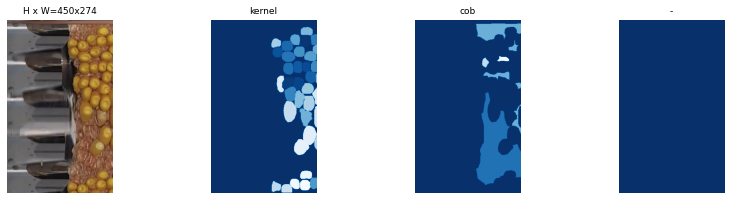

1396_3_1203_s1


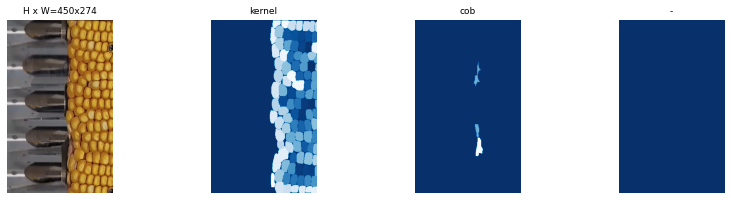

1137_1_429_s1


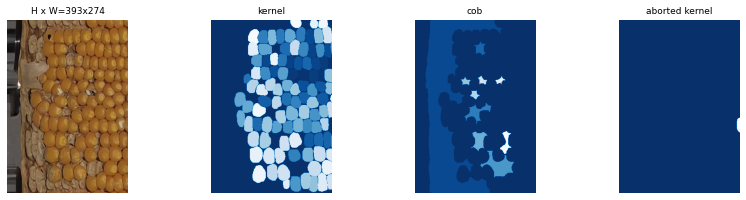

1396_1_1203_s1


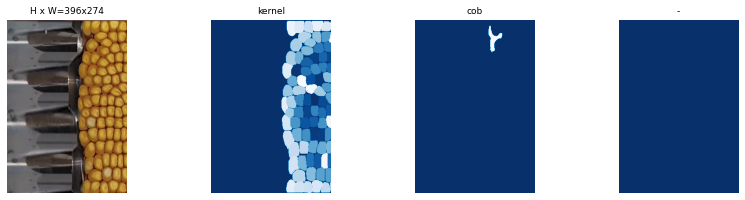

1405_3_1203_s2


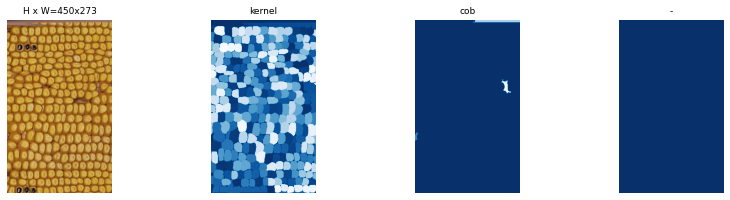

1107_3_515_s1


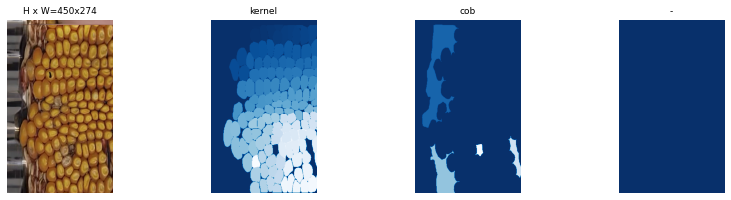

1397_1_1203_s2


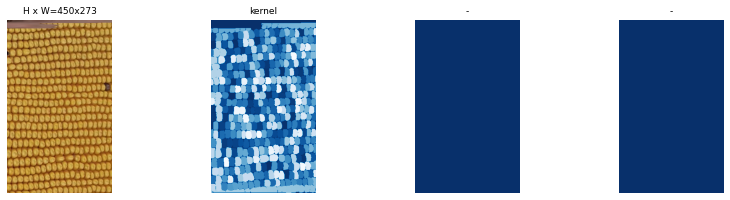

1145_1_429_s2


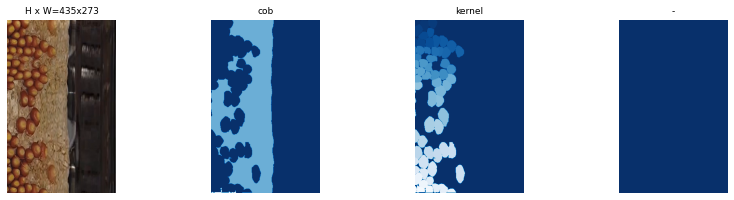

1408_2_1203_s3


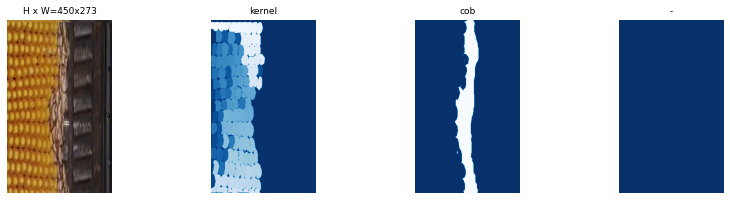

1404_3_1203_s2


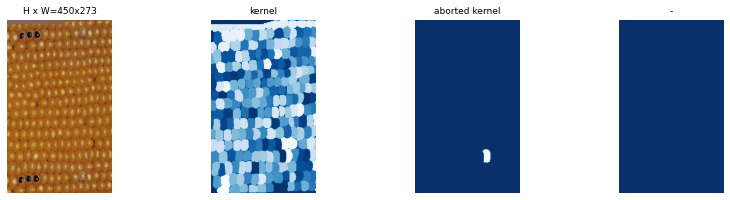

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 10)
for image_id in image_ids:
    print(dataset.image_info[image_id]["id"])
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=3)

## Create Model 

In [ ]:
 model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
init_with = 'coco'
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

In [ ]:
dataset_dir = "/content/Mask_RCNN/datasets/split"
maize.train(model, config, dataset_dir, "list")

##Detection

In [ ]:
%cd maize
!python maize.py detect --dataset=/content/Mask_RCNN/datasets/unlabeled/Cchristenson3_Maize_Images/v0.5 --weights=/content/Mask_RCNN/mask_rcnn_maize_0117.h5 --logs=/content/Mask_RCNN/logs --subset=train --split_num=3

/content/Mask_RCNN/samples/maize
Using TensorFlow backend.
Weights:  /content/Mask_RCNN/mask_rcnn_maize_0117.h5
Dataset:  /content/Mask_RCNN/datasets/unlabeled/Cchristenson3_Maize_Images/v0.5
Subset:  train
Logs:  /content/Mask_RCNN/logs

Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASS_WEIGHTS                  None
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        2000
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARN

## Evaluate

In [ ]:
from sklearn import metrics
def compute_ar(pred_boxes, gt_boxes, list_iou_thresholds):

    AR = []
    for iou_threshold in list_iou_thresholds:

        try:
            recall, _ = utils.compute_recall(pred_boxes, gt_boxes, iou=iou_threshold)

            AR.append(recall)

        except:
            AR.append(0.0)
            pass

    AUC = 2 * (metrics.auc(list_iou_thresholds, AR))
    return AUC


def evaluate_model(
    model,
    dataset,
    config,
    limit=0,
    image_ids=None,
    type=str,
    split_num=3,
    list_iou_thresholds=None,
):
    assert split_num in [1, 3]
    image_ids = image_ids or dataset.image_ids

    # Limit to a subset
    if limit:
        image_ids = image_ids[:limit]

    if list_iou_thresholds is None:
        list_iou_thresholds = np.arange(0.5, 1.01, 0.1)

    if type == "range":
        image_id = np.random.choice(image_ids)
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
            dataset, config, image_id, use_mini_mask=False
        )
        info = dataset.image_info[image_id]

        # Run object detection
        r = maize.detect_splits(model, image, split_num)

        utils.compute_ap_range(
            gt_bbox,
            gt_class_id,
            gt_mask,
            r["rois"],
            r["class_ids"],
            r["scores"],
            r["masks"],
            verbose=1,
        )

        visualize.display_differences(
            image,
            gt_bbox,
            gt_class_id,
            gt_mask,
            r["rois"],
            r["class_ids"],
            r["scores"],
            r["masks"],
            dataset.class_names,
            show_box=False,
            show_mask=False,
            iou_threshold=0.5,
            score_threshold=0.5,
        )

    elif type == "batch":
        ARs = []
        APs = []
        for image_id in image_ids:
            image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
                dataset, config, image_id, use_mini_mask=False
            )
            info = dataset.image_info[image_id]
            print(
                "image ID: {}.{} ({}) {}".format(
                    info["source"],
                    info["id"],
                    image_id,
                    dataset.image_reference(image_id),
                )
            )
            # Run object detection
            r = maize.detect_splits(model, image, split_num)

            AP, precisions, recalls, overlaps = utils.compute_ap(
                gt_bbox,
                gt_class_id,
                gt_mask,
                r["rois"],
                r["class_ids"],
                r["scores"],
                r["masks"],
            )

            AR = compute_ar(r["rois"], gt_bbox, list_iou_thresholds)
            ARs.append(AR)
            APs.append(AP)

        mAP = np.mean(APs)
        mAR = np.mean(ARs)

        return mAP, mAR

In [ ]:
class MaizeInferenceConfig(MaizeConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.5
    
config = MaizeInferenceConfig()

In [ ]:
test_ids = ['1646_2', '1787_2_1203', '1406_3_1203', '1443_3_515', '1816_2_1203', '1402_3_1203', '1793_3_1203', '1395_2_1203', '1443_1_515', '1793_1_1203', '1787_3_1203', '1155_1_515', '1404_3_1203', '1805_1_1203', '1409_3_1203', '1401_2_1203', '1419_1_1203', '1394_3_1203', '1443_2_515', '1798_2_1203']
maize.LIST_IMAGE_IDS = test_ids

In [ ]:
MODEL_PATH ="/content/Mask_RCNN/mask_rcnn_maize_0117.h5" # Change to Imported Model
model = modellib.MaskRCNN(mode="inference", config=config,
                          model_dir=MODEL_DIR)
model.load_weights(MODEL_PATH, by_name=True)

dataset = maize.MaizeDataset()
dataset.load_maize(dataset_dir="/content/Mask_RCNN/datasets/full/Cchristenson3_Maize_Images/v0.3", subset="list") 
dataset.prepare()

In [ ]:
image_ids = dataset.image_ids
maize.temp_eval(model, dataset, config, type="range")

In [ ]:
mAP, mAR = evaluate_model(model, dataset, config ,type="batch")

In [ ]:
print("mAP @ IoU=50: ", mAP)
print("mAR @ IoU=50: ", mAR)

##Export to Segments


In [ ]:
data_dir = "/content/Mask_RCNN/datasets/unlabeled/Cchristenson3_Maize_Images/v0.5"

In [ ]:
from segments import SegmentsClient, SegmentsDataset
client = SegmentsClient("bae8274c0c630065ab9b3127a8b70fd4ccae6363")
dataset_name = "Cchristenson3/Maize_Images"
release_version = "v0.5"
release = client.get_release(dataset_name, release_version)

data = SegmentsDataset(release)
uuid_dict ={}
for sample in data:
    file_n = sample['file_name']
    uuid = sample["uuid"]
    uuid_dict.update({file_n:uuid})

Initialized successfully.
Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 1280/1280 [01:01<00:00, 20.79it/s]


Initialized dataset with 1280 images.


In [ ]:
from segments.utils import bitmap2file

In [ ]:
annotations_path = osp.join(data_dir, "predictions_annotations.json")
with open(annotations_path) as f:
    annotations=json.load(f)

# Upload the predictions to Segments.ai
file_names = next(os.walk(data_dir))[2]
for filename in file_names:
    if not filename.split("_")[-1] == "label.png":
        continue
    image_name = filename.split("_pred")[0]
    print(image_name)

    bitmap_path = osp.join(data_dir, filename)
    bitmap = skimage.io.imread(bitmap_path).astype(np.uint32)
    file = bitmap2file(bitmap)
    asset = client.upload_asset(file, 'label.png')

    image_annotations = []
    for annotation in annotations:
        if annotation["image_name"] == image_name:
            class_ids = annotation["class_ids"]
            image_annotations= [
                {"id": instance.get("id"), "category_id": instance.get("class_id")}
                for instance in class_ids
            ]
            
    attributes = {
        'format_version': '0.1',
        'annotations': image_annotations,
        'segmentation_bitmap': { 'url': asset['url'] }, 
    }

    #Make sure to add a labelset to segments and change it in the code
    client.add_label(uuid_dict[f"{image_name}.png"], 'model-predictions', attributes)

2740_2_1028
2228_1_1203
2708_1_1102
2161_4_1102
1219_1_1030
2063_2_1030
1144_2_1119
2143_1_1102
1093_3_1111
2147_1_1102
1673_2_1028
2704_2_1030
4333_3_515
1217_2_1030
1203_3_1030
2788_1_1030
1201_2_1030
2692_2_1029
2164_3_1102
2687_3_1029
2652_3_1030
1673_1_1028
2839_1_1102
2152_3_1102
2675_3_1029
2429_3_1030
2549_2_1111
2154_2_1102
1795_1_1203
4021_1_515
2122_1_1119
2147_2_1102
1143_2_1119
4329_1_515
1805_3_1203
1099_1_1111
1160_3_1119
2072_1_1030
2839_3_1102
2142_2_1102
2550_3_1111
2164_2_1102
2669_1_1030
3177_2_429
2151_2_1102
2558_4_1111
2548_2_1111
2826_2_1102
2423_1_1030
1818_1_1203
2066_2_1030
1833_1_1203
2621_2_1203
2671_3_1030
1411_3_1203
4241_3_515
1690_3_1029
1197_2_1030
1155_1_1119
2744_2_1028
2550_2_1111
2814_1_1102
1198_2_1030
2138_1_1119
1472_1_1102
1517_3_1119
1213_3_1030
1470_2_1102
2630_1_1203
2120_1_1119
1154_1_1119
2681_2_1029
1220_2_1030
1417_2_1203
1475_3_1102
2749_1_1028
1676_3_1028
2247_1_1203
2444_1_1030
1222_3_1030
2807_2_1030
4005_3_515
2536_1_1111
1212_1_103

In [ ]:
print(image_annotations)

[{'id': 1, 'category_id': 1}, {'id': 2, 'category_id': 1}, {'id': 3, 'category_id': 1}, {'id': 4, 'category_id': 1}, {'id': 5, 'category_id': 1}, {'id': 6, 'category_id': 1}, {'id': 7, 'category_id': 1}, {'id': 8, 'category_id': 1}, {'id': 9, 'category_id': 1}, {'id': 10, 'category_id': 1}, {'id': 11, 'category_id': 1}, {'id': 12, 'category_id': 1}, {'id': 13, 'category_id': 1}, {'id': 14, 'category_id': 1}, {'id': 15, 'category_id': 1}, {'id': 16, 'category_id': 1}, {'id': 17, 'category_id': 1}, {'id': 18, 'category_id': 1}, {'id': 19, 'category_id': 1}, {'id': 20, 'category_id': 1}, {'id': 21, 'category_id': 1}, {'id': 22, 'category_id': 1}, {'id': 23, 'category_id': 1}, {'id': 24, 'category_id': 1}, {'id': 25, 'category_id': 1}, {'id': 26, 'category_id': 1}, {'id': 27, 'category_id': 1}, {'id': 28, 'category_id': 1}, {'id': 29, 'category_id': 1}, {'id': 30, 'category_id': 1}, {'id': 31, 'category_id': 1}, {'id': 32, 'category_id': 1}, {'id': 33, 'category_id': 1}, {'id': 34, 'catego

## Command-Line Commands

In [ ]:
!python maize.py train --dataset=/content/Mask_RCNN/datasets/split --weights=coco --subset=train

In [ ]:
!python maize.py detect --dataset=/content/Mask_RCNN/datasets/test/Cchristenson3_Mazie_Images/v2.0 --weights=/content/Mask_RCNN/logs/maize20220513T1419/mask_rcnn_maize_0027.h5 --subset=train --split_num=3